# Quality control for regridding efforts

Use this notebook to check the quality of the regridded data.

In [12]:
# from multiprocessing import Pool
import cftime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from pandas.errors import OutOfBoundsDatetime
from config import *
from regrid import open_and_crop_dataset, prod_lat_slice


### Evaluate regridding

Here we will perform a qualitative assessment of the regridding by plotting multiple comparisons of files with each other.

In [13]:
#optionally, use a local regrid dir or data subset
#regrid_dir = Path('/center1/CMIP6/jdpaul3/cmip6_regridding_2/regrid/CESM2-WACCM/ssp245')

regrid_fps = list(regrid_dir.glob("**/*.nc"))

In [14]:
def get_matching_time_filepath(fps, test_date):
    """Find a file from a given list of raw CMIP6 filepaths that conatins the test date within the timespan in the filename."""
    matching_fps = []
    for fp in fps:
        start_str, end_str = fp.name.split(".nc")[0].split("_")[-1].split("-")
        start_str = f"{start_str}01" if len(start_str) == 6 else start_str
        # end date should be constructed as the end of month for monthly data
        #  (and should always be December??)
        end_str = f"{end_str}31" if len(end_str) == 6 else end_str
        format_str = "%Y%m%d"
        try:
            start_dt = pd.to_datetime(start_str, format=format_str)
            # it should be OK if end date is
            end_dt = pd.to_datetime(end_str, format=format_str)
        except OutOfBoundsDatetime:
            # we should not be regridding files with time values that cause this (2300 etc)
            continue

        if start_dt <= test_date < end_dt:
            matching_fps.append(fp)

    # there should only be one
    assert len(matching_fps) == 1

    return matching_fps[0]


def generate_cmip6_filepath_from_regrid_filename(fn):
    """Get the path to the original CMIP6 filename from a regridded file name.

    Because the original CMIP6 filenames were split up during the processing, this method finds the original filename based on matching all possible attributes, then testing for inclusion of regrid file start date within the date range formed by the CMIP6 file timespan.
    """
    var_id, freq, model, scenario, _, timespan = fn.split(".nc")[0].split("_")
    institution = model_inst_lu[model]
    experiment_id = "ScenarioMIP" if scenario in prod_scenarios else "CMIP"
    # Construct the original CMIP6 filepath from the filename.
    # Need to use glob because of the "grid type" filename attribute that we do not have a lookup for.
    var_dir = cmip6_dir.joinpath(f"{experiment_id}/{institution}/{model}/{scenario}")
    glob_str = f"*/{freq}/{var_id}/*/*/{var_id}_{freq}_{model}_{scenario}_*.nc"
    candidate_fps = list(var_dir.glob(glob_str))

    start_str = timespan.split("-")[0]
    format_str = "%Y%m" if len(start_str) == 6 else "%Y%m%d"
    start_dt = pd.to_datetime(start_str, format=format_str)
    cmip6_fp = get_matching_time_filepath(candidate_fps, start_dt)

    return cmip6_fp


def plot_comparison(regrid_fp):
    src_fp = generate_cmip6_filepath_from_regrid_filename(regrid_fp.name)
    src_ds = open_and_crop_dataset(src_fp, lat_slice=prod_lat_slice)
    regrid_ds = xr.open_dataset(regrid_fp)
    lat_slice = slice(55, 75)
    lon_slice_src = slice(200, 240)
    lon_slice_regrid = slice(-160, -120)
    time_val = regrid_ds.time.values[0]
    var_id = src_ds.attrs["variable_id"]

    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(
        f"Variable: {var_id}     Model: {src_ds.attrs['source_id']}     Scenario: {src_ds.attrs['experiment_id']}"
    )

    # now, there are multiple possible time formats for the source dataset.
    # convert the chosen time value to that matching format for subsetting.
    sel_method = None
    if isinstance(src_ds.time.values[0], cftime._cftime.Datetime360Day):
        src_hour = src_ds.time.dt.hour[0]
        src_time = cftime.Datetime360Day(
            year=time_val.year, month=time_val.month, day=time_val.day, hour=src_hour
        )
    elif isinstance(
        src_ds.time.values[0], pd._libs.tslibs.timestamps.Timestamp
    ) or isinstance(src_ds.time.values[0], np.datetime64):
        src_hour = src_ds.time.dt.hour[0]
        src_time = pd.to_datetime(
            f"{time_val.year}-{time_val.month}-{time_val.day}T{src_hour}:00:00"
        )
    else:
        if time_val not in src_ds.time.values:
            src_hour = src_ds.time.dt.hour[0]
            src_time = cftime.DatetimeNoLeap(
                year=time_val.year,
                month=time_val.month,
                day=time_val.day,
                hour=src_hour,
            )
        else:
            src_time = time_val
    if src_time not in src_ds.time.values:
        if src_ds.attrs["frequency"] == "mon":
            # too much variability in day used (e.g. 14, 15, 16), "nearest" method for selection will work
            sel_method = "nearest"
        else:
            print(src_time)
            print(src_ds.time)
            assert False

    #get a vmin and vmax from src dataset to use for both plots, if a map
    vmin = src_ds[var_id].sel(time=src_time, method=sel_method).sel(lat=lat_slice, lon=lon_slice_src).values.min()
    vmax = src_ds[var_id].sel(time=src_time, method=sel_method).sel(lat=lat_slice, lon=lon_slice_src).values.max()
    try: #maps
        src_ds[var_id].sel(time=src_time, method=sel_method).sel(lat=lat_slice, lon=lon_slice_src).plot(ax=axes[0], vmin=vmin, vmax=vmax)
        axes[0].set_title(f"Source dataset (timestamp: {src_time})")
        regrid_ds[var_id].sel(time=time_val).sel(lat=lat_slice, lon=lon_slice_regrid).plot(ax=axes[1], vmin=vmin, vmax=vmax)
        axes[1].set_title(f"Regridded dataset (timestamp: {time_val})")
        plt.show()

    except: #histograms
        src_ds[var_id].sel(time=src_time, method=sel_method).sel(lat=lat_slice, lon=lon_slice_src).plot(ax=axes[0])
        axes[0].set_title(f"Source dataset (timestamp: {src_time})")
        regrid_ds[var_id].sel(time=time_val).sel(lat=lat_slice, lon=lon_slice_regrid).plot(ax=axes[1])
        axes[1].set_title(f"Regridded dataset (timestamp: {time_val})")
        plt.show()

Now, randomly select and plot comparisons for a subset of the files using an Alaska-ish domain for some added zoom.

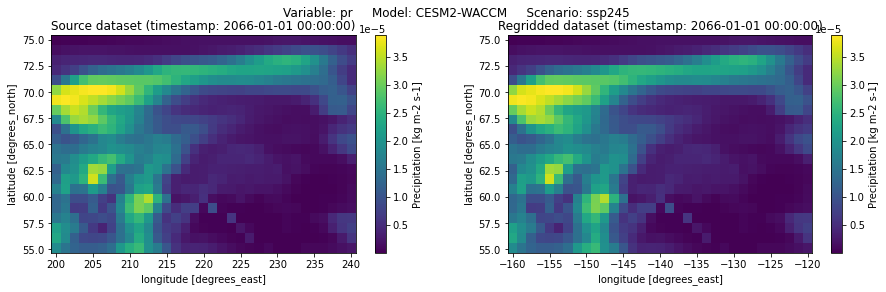

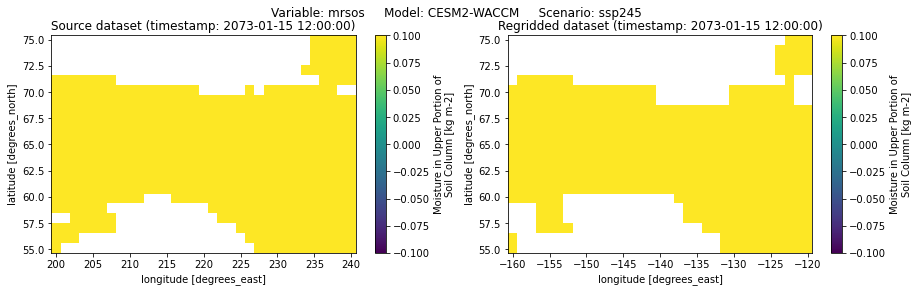

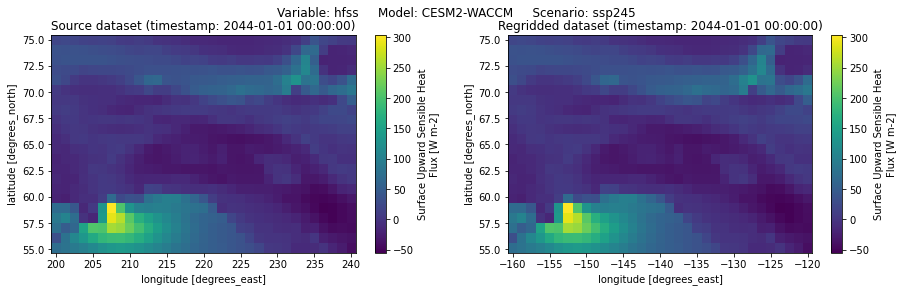

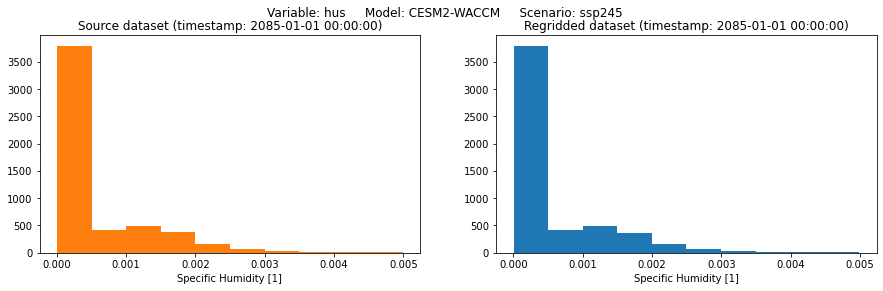

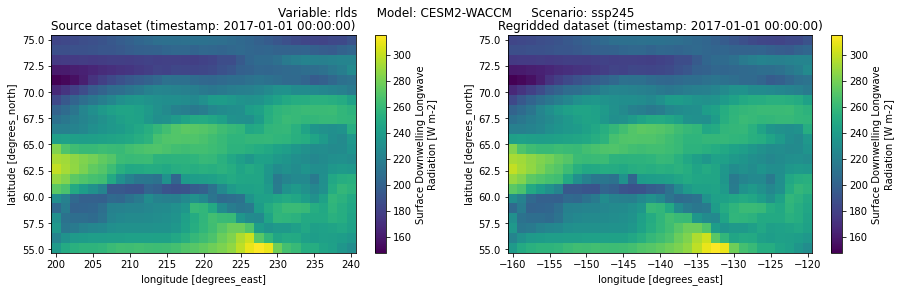

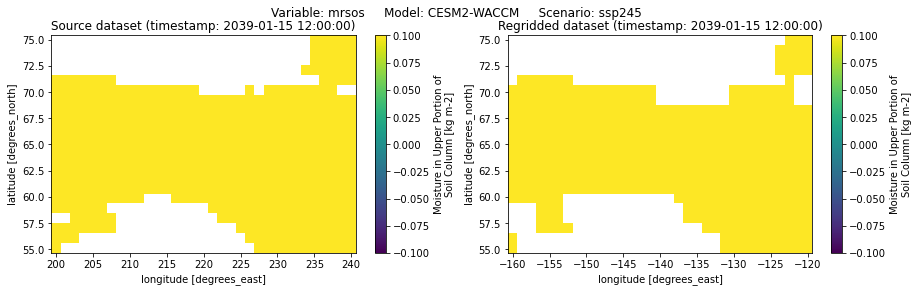

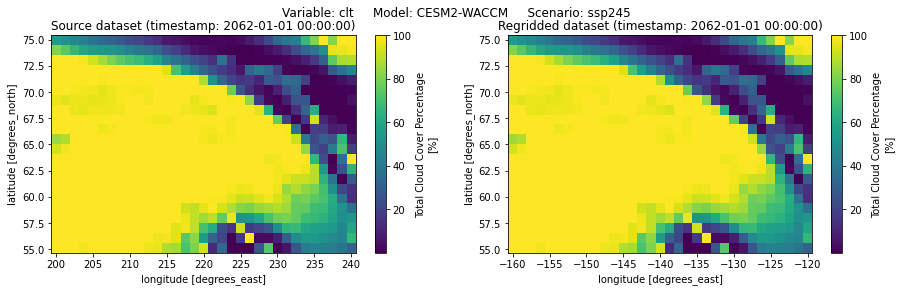

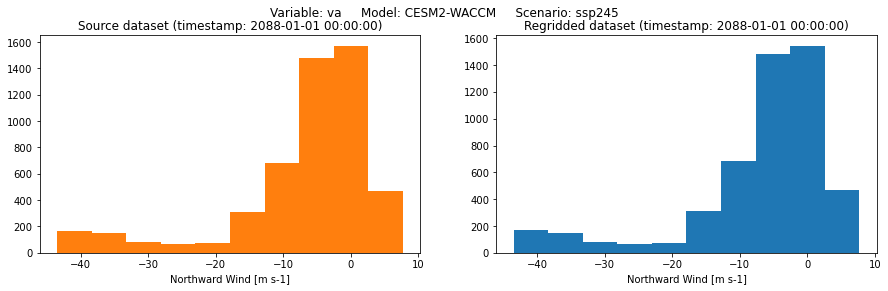

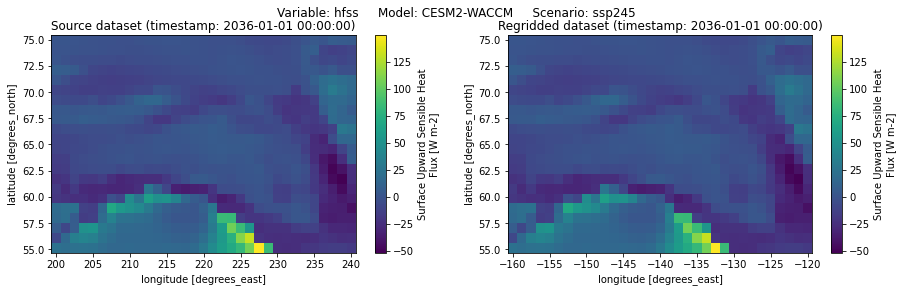

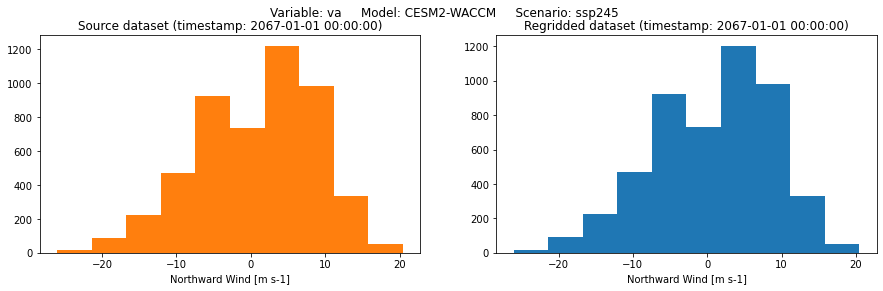

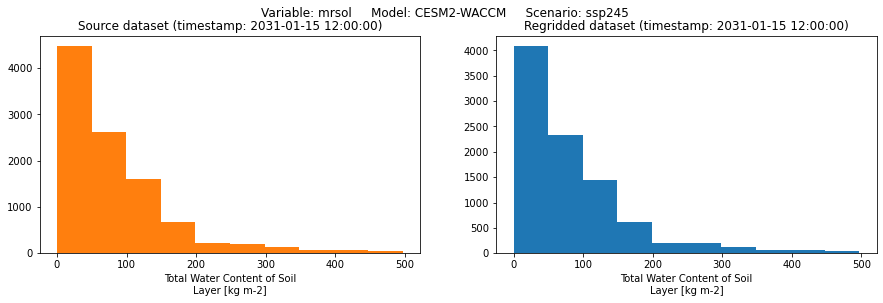

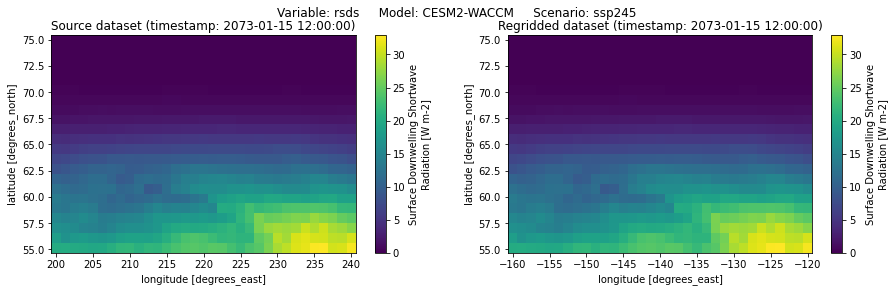

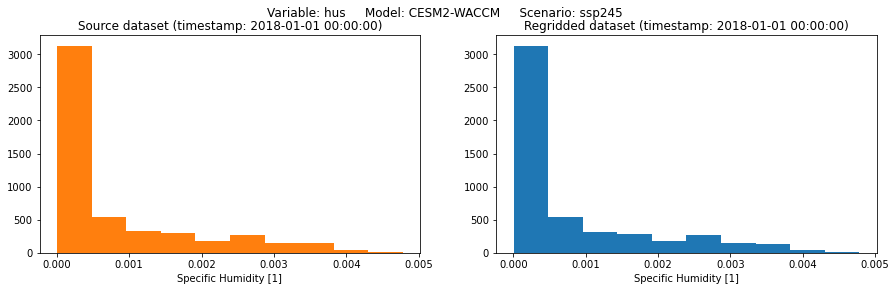

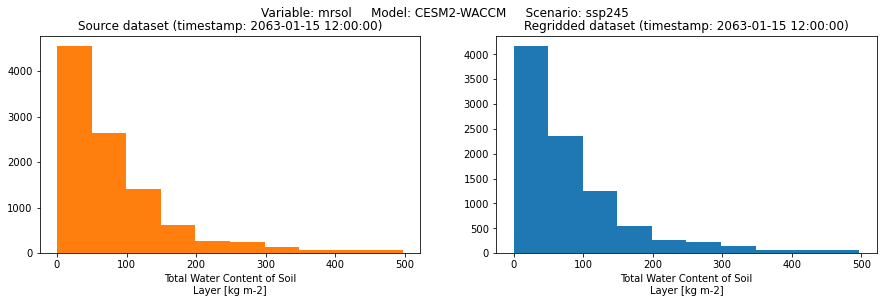

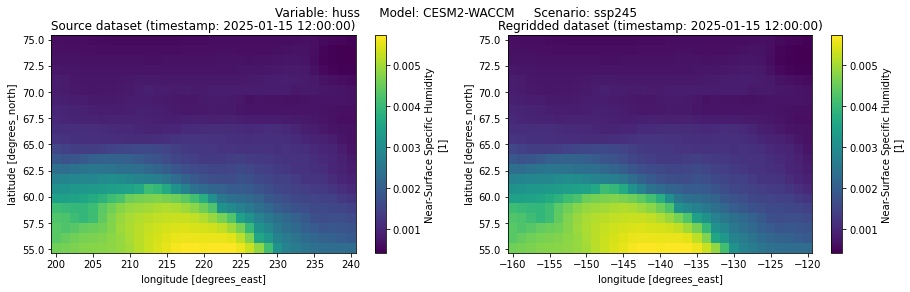

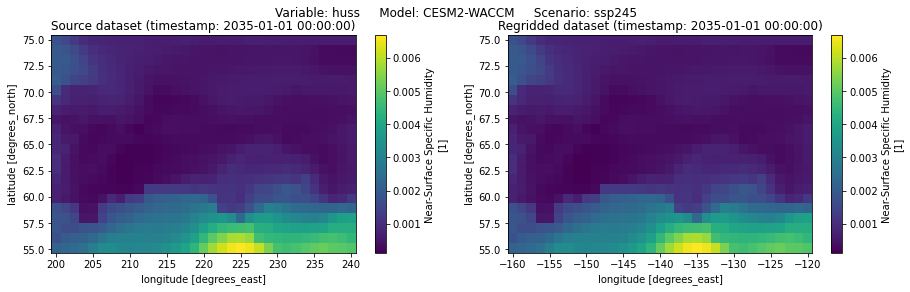

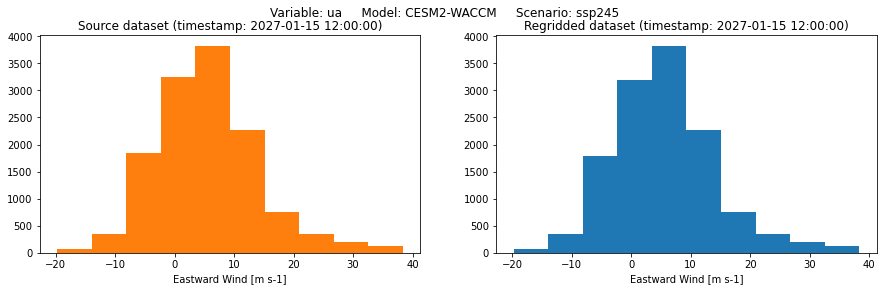

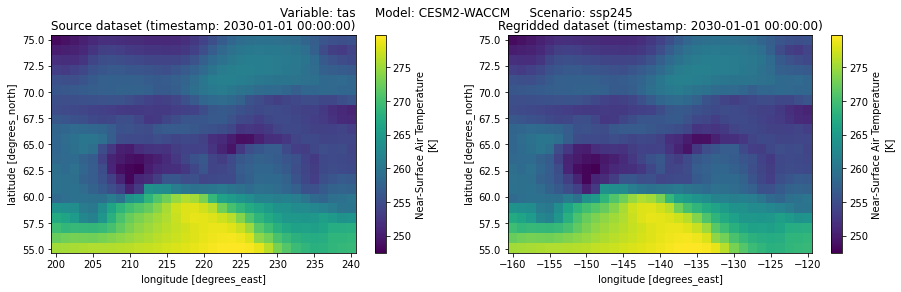

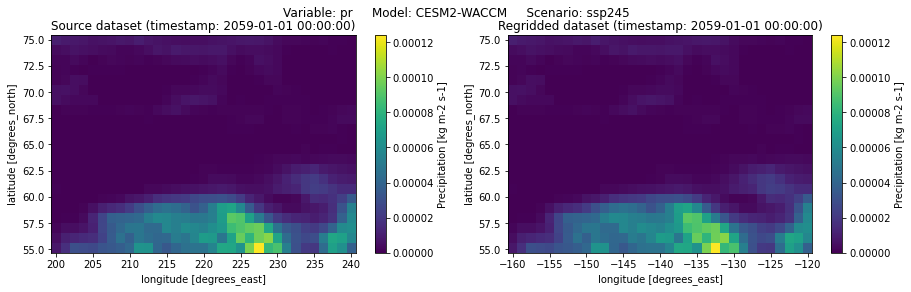

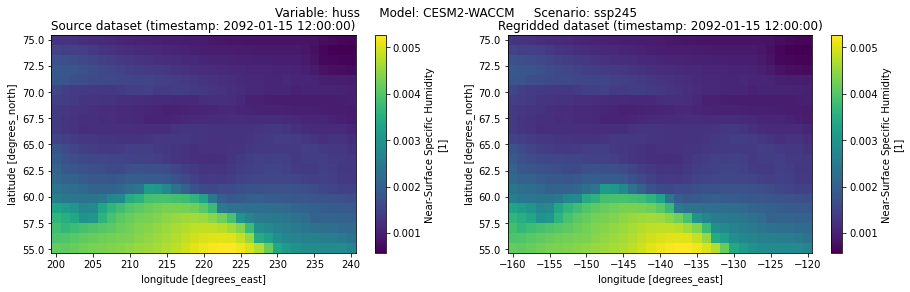

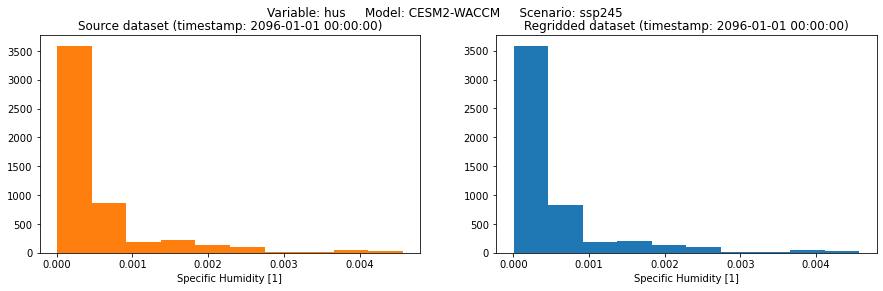

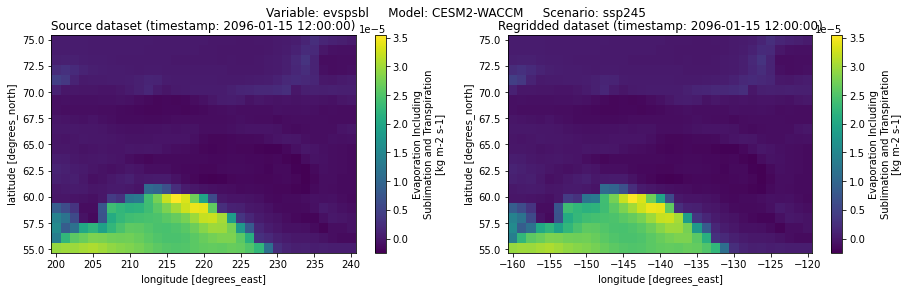

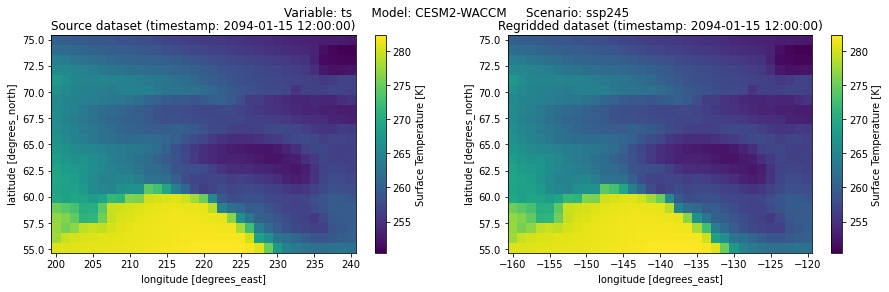

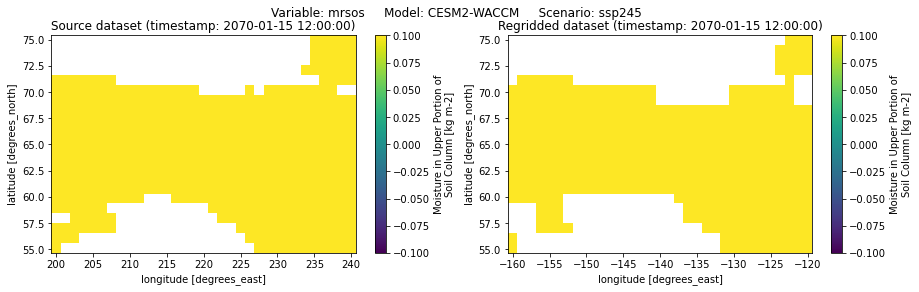

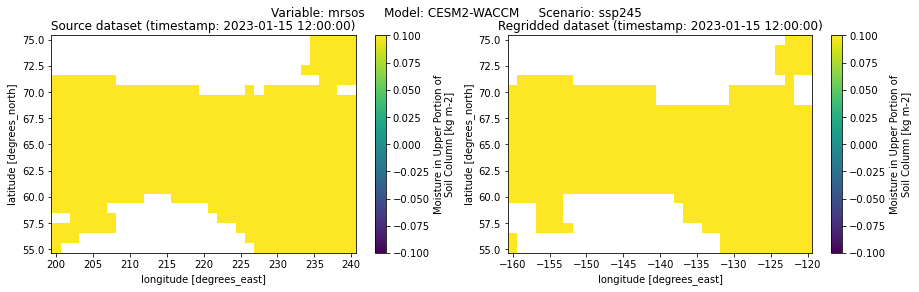

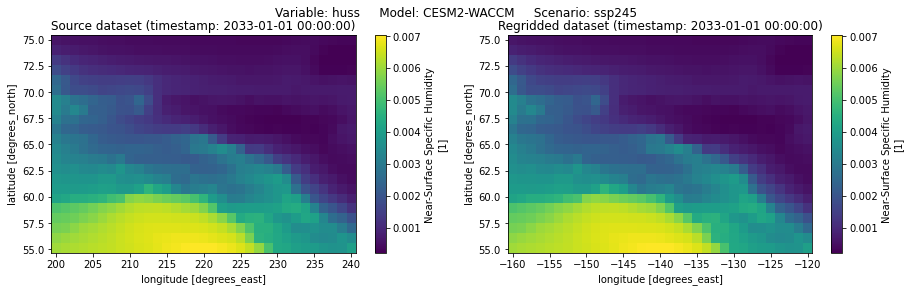

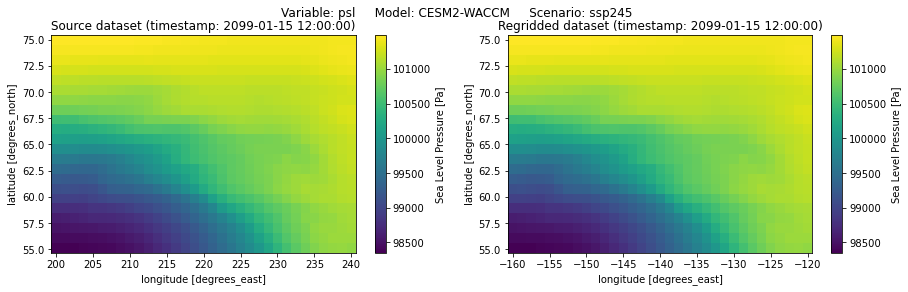

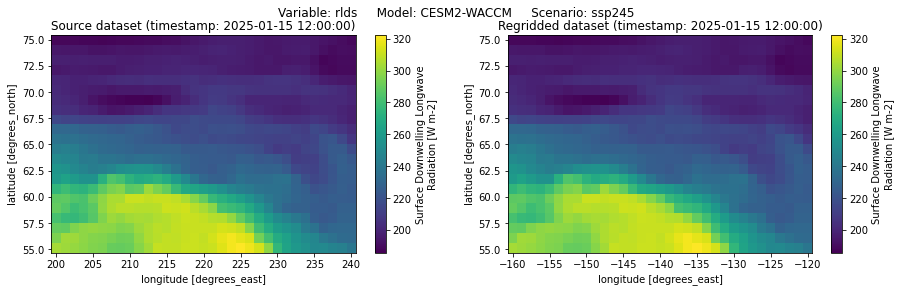

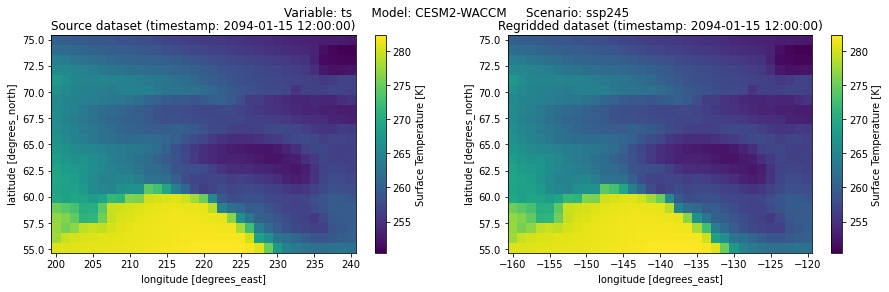

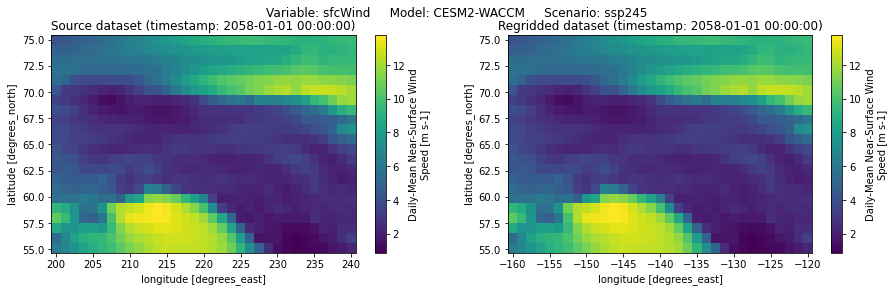

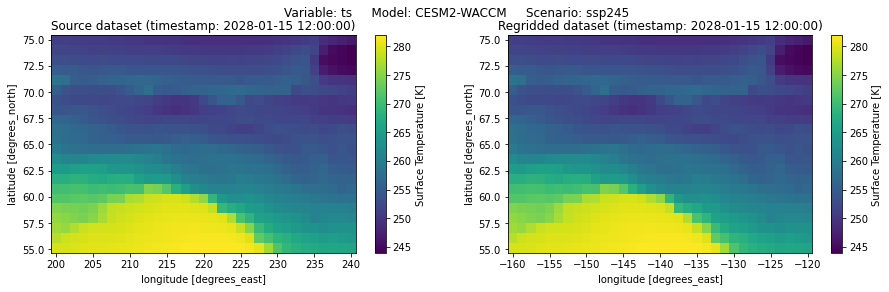

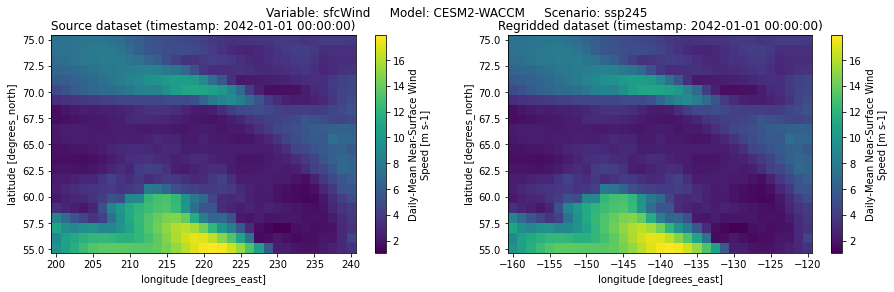

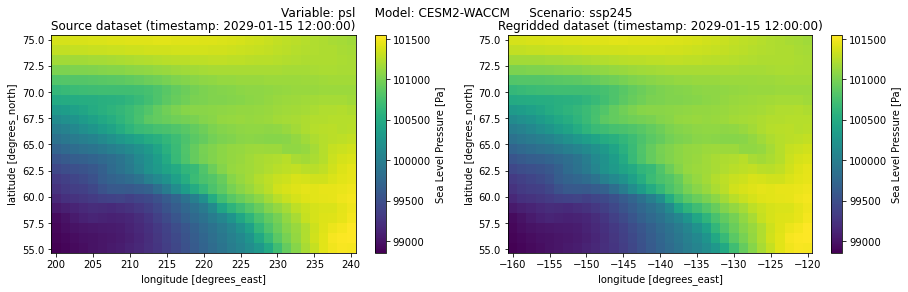

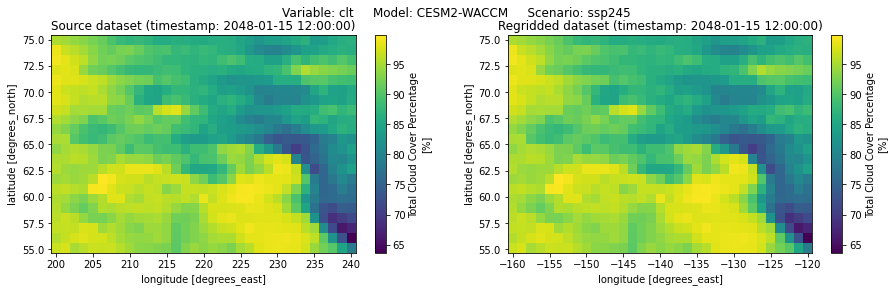

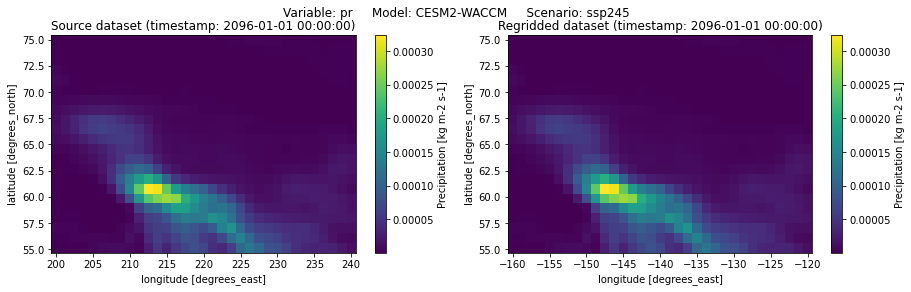

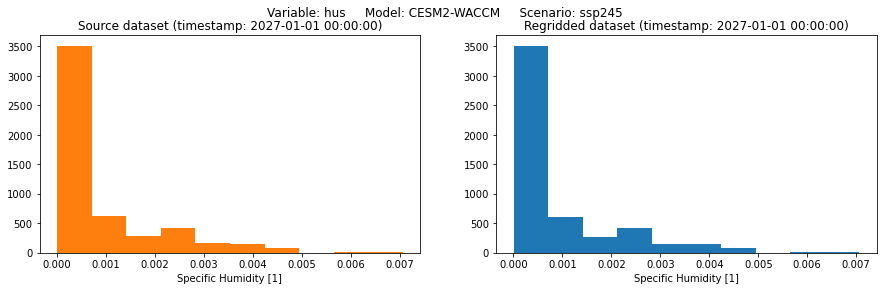

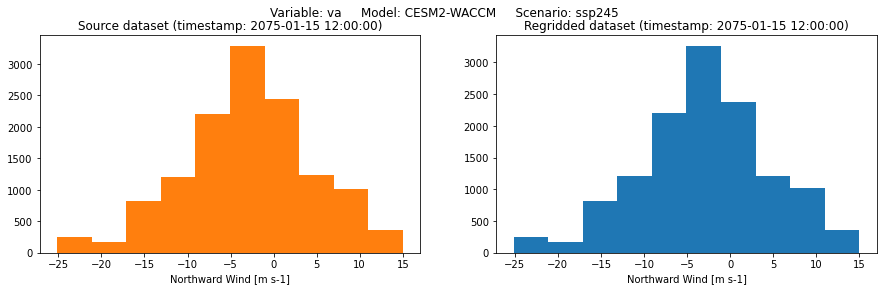

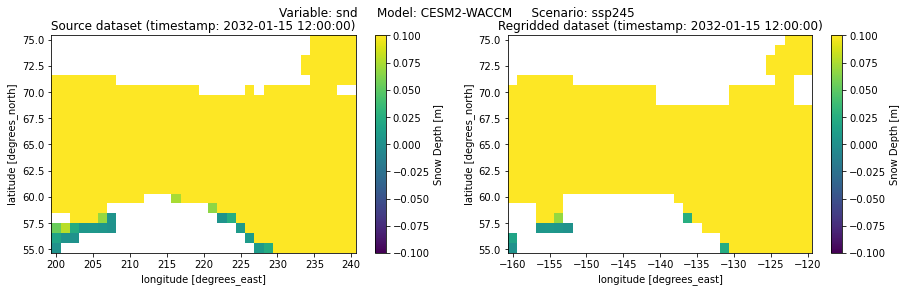

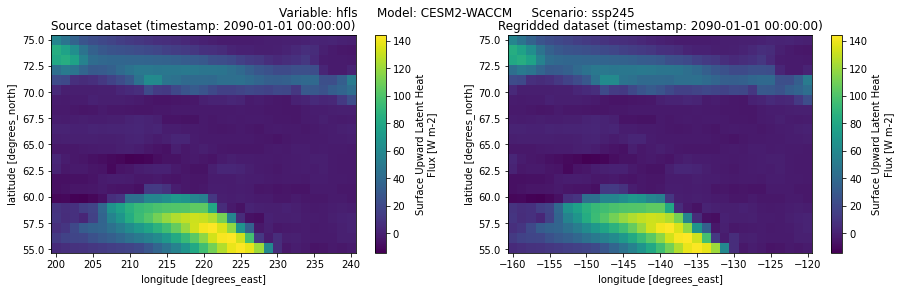

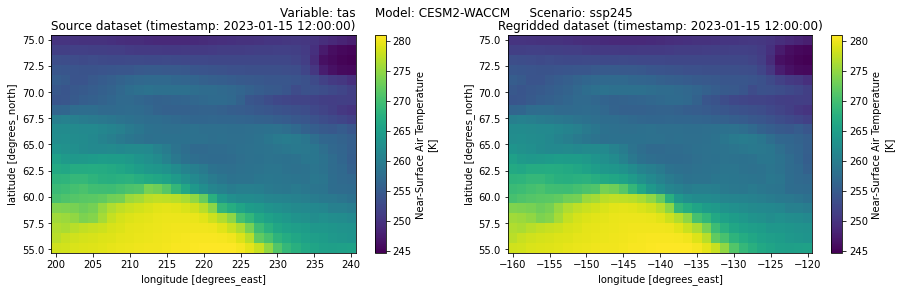

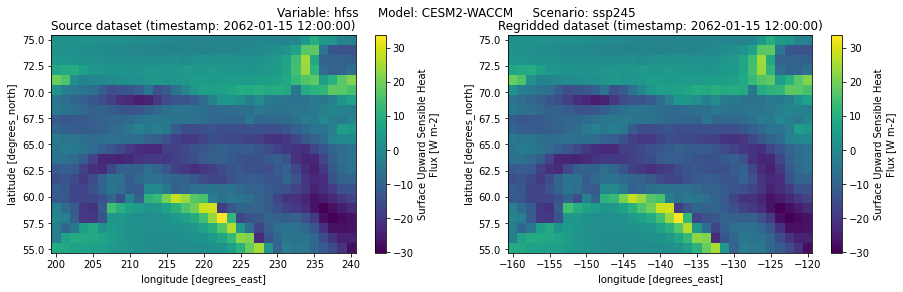

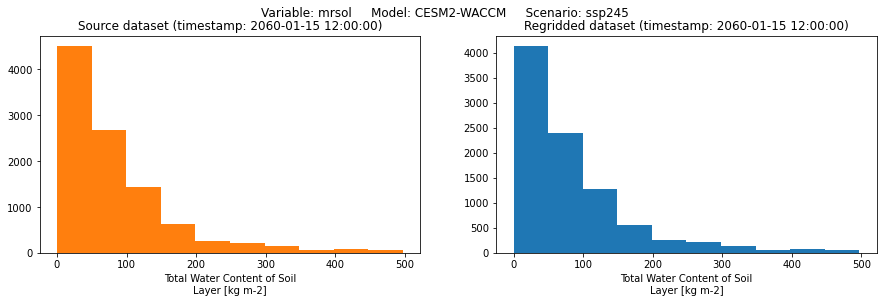

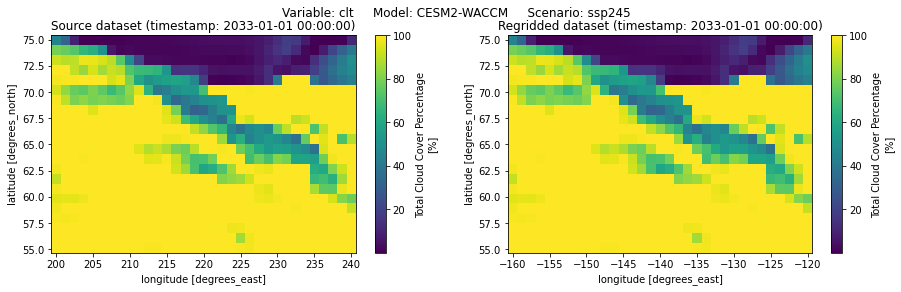

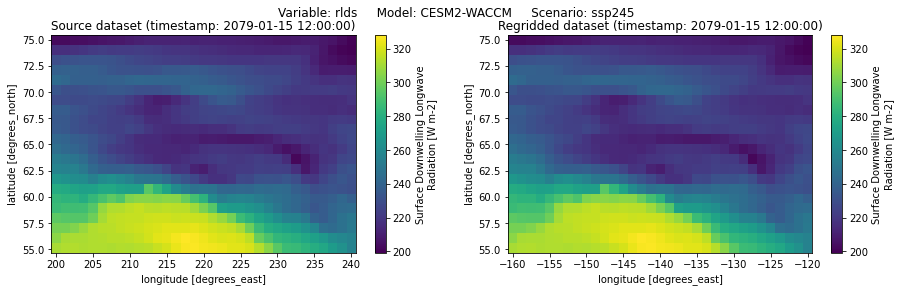

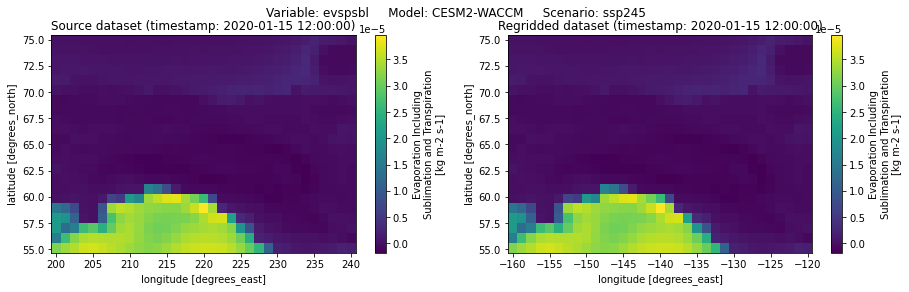

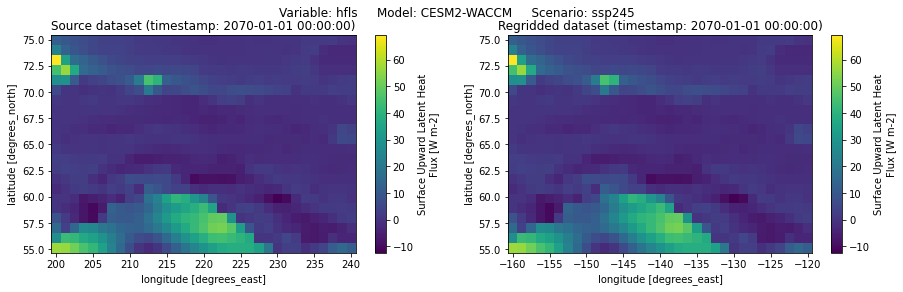

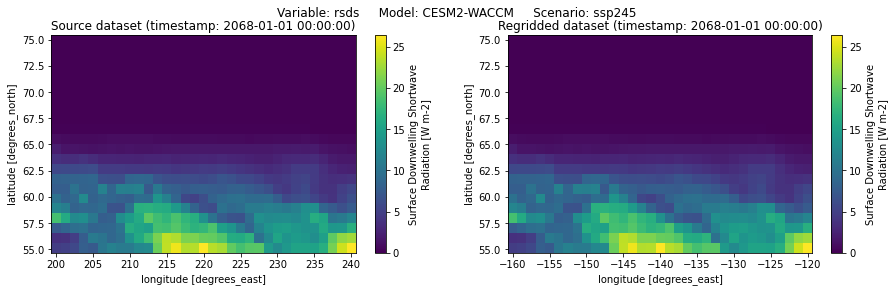

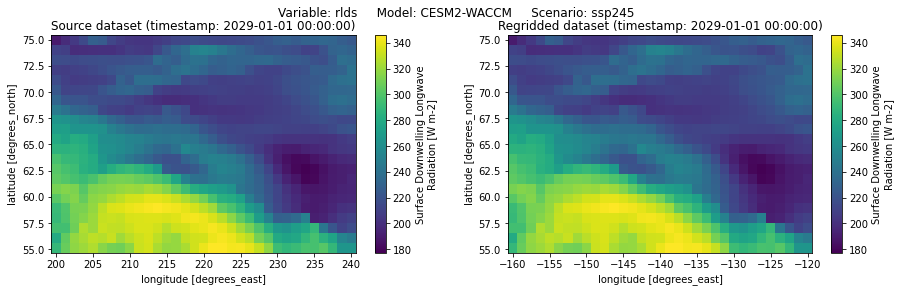

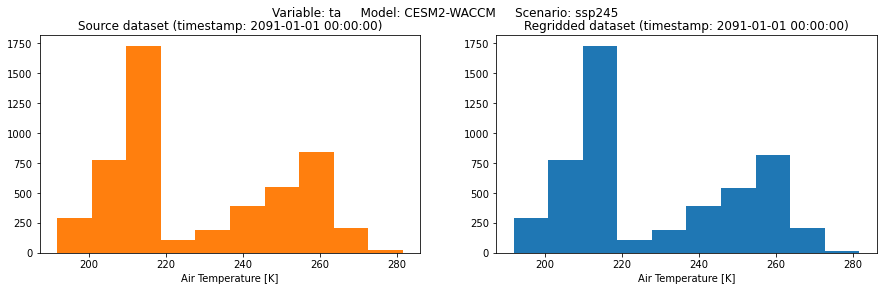

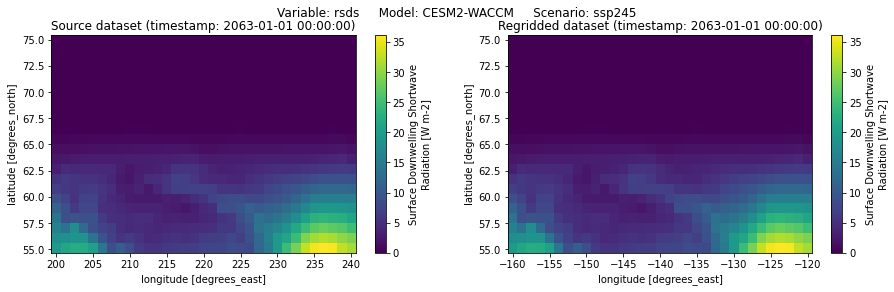

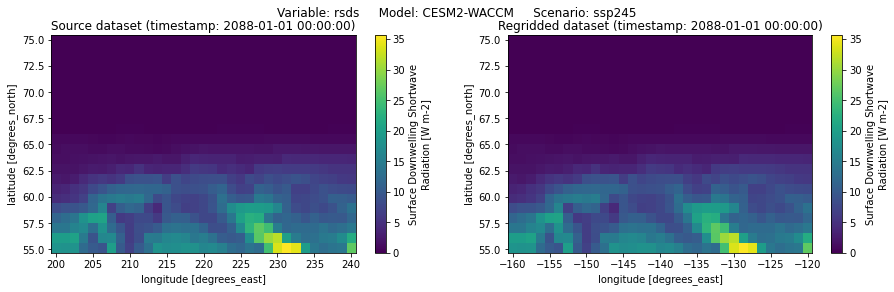

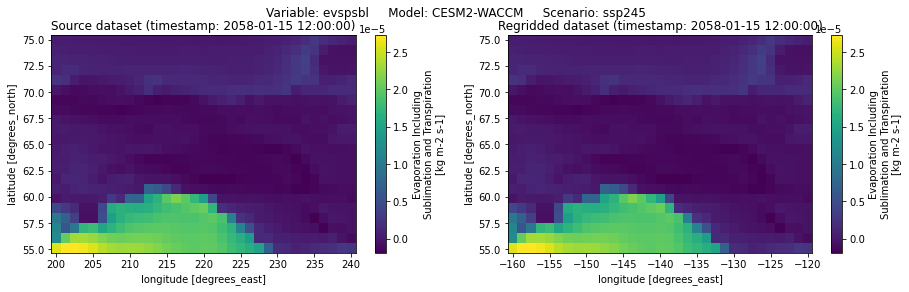

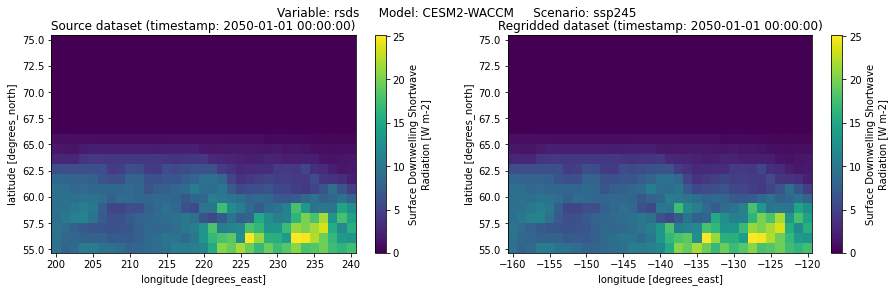

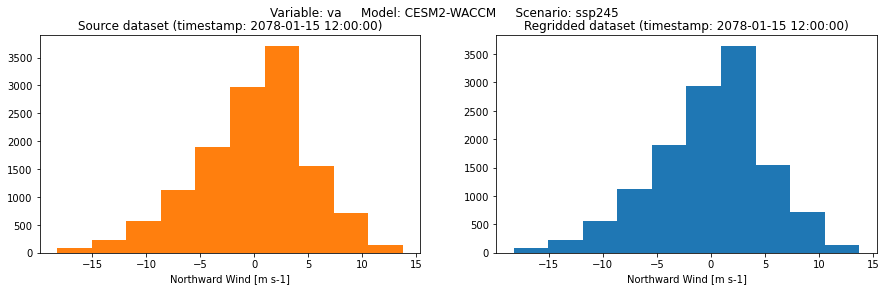

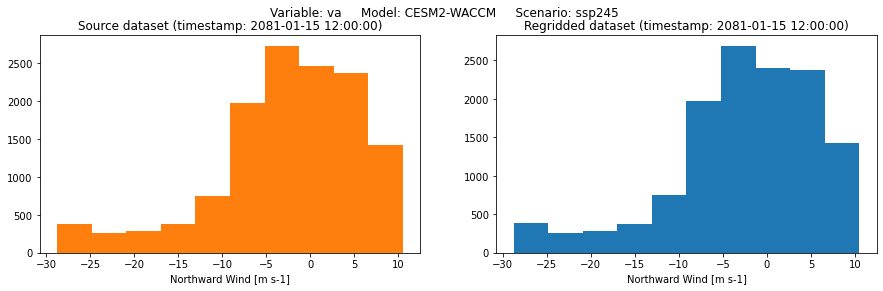

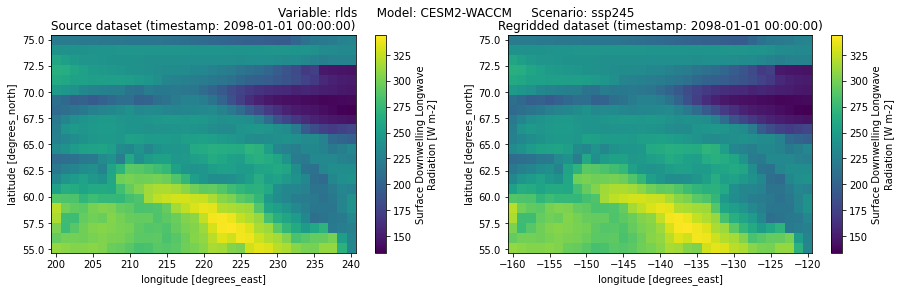

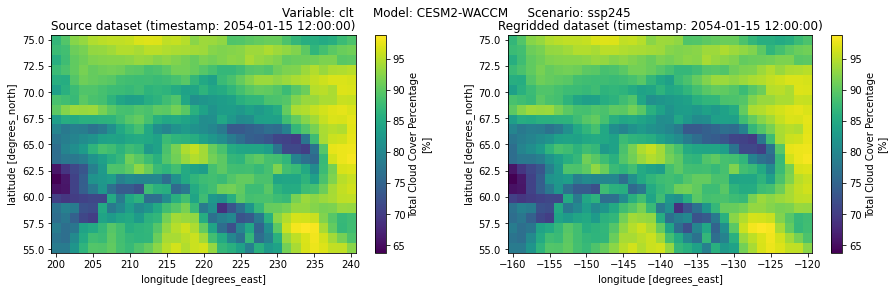

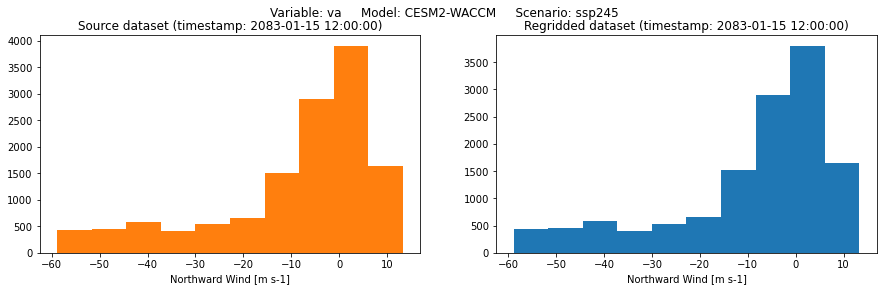

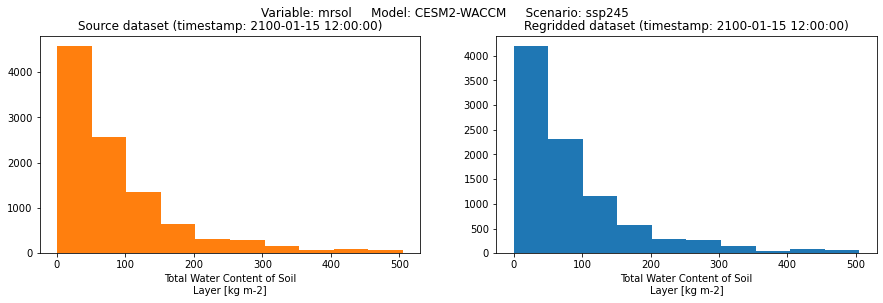

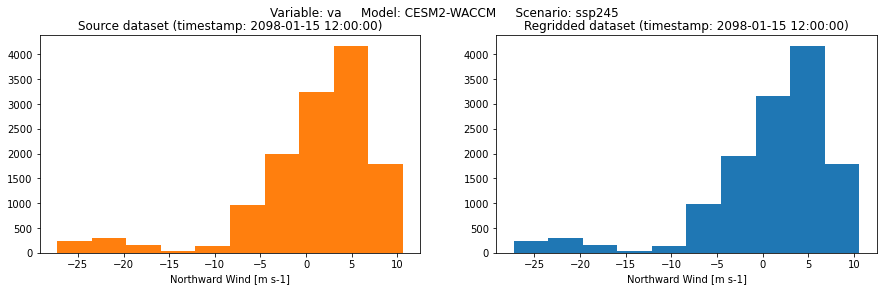

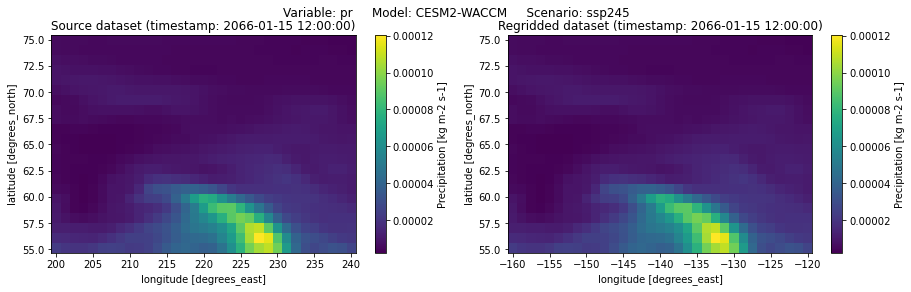

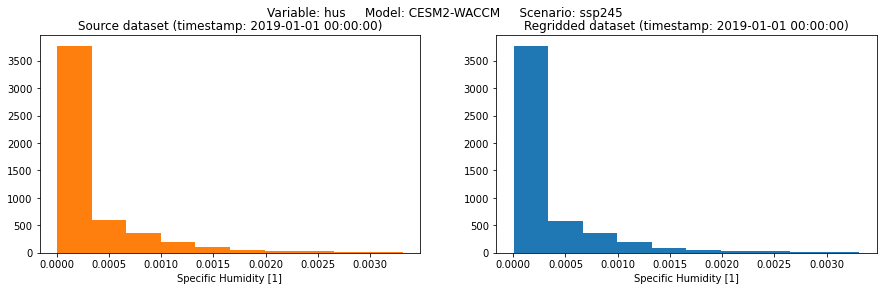

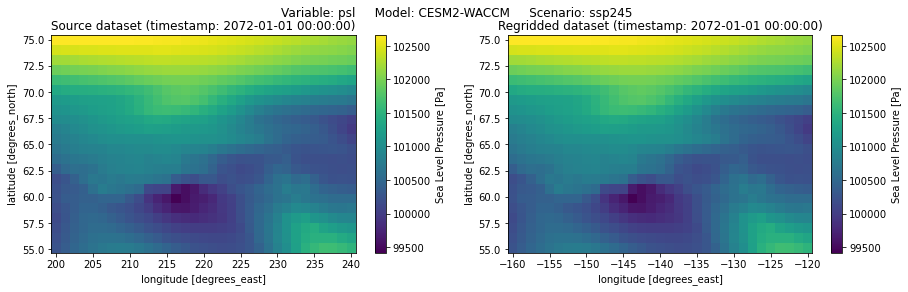

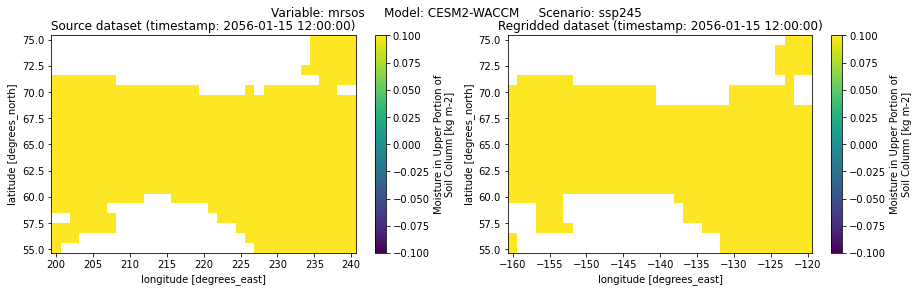

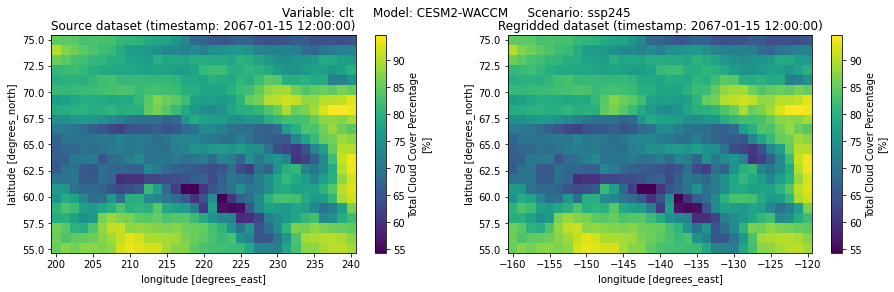

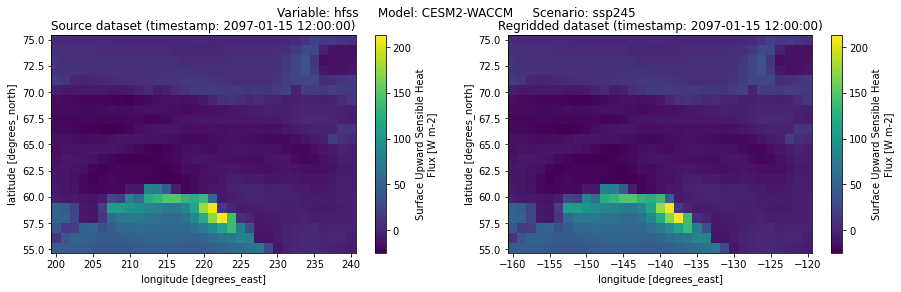

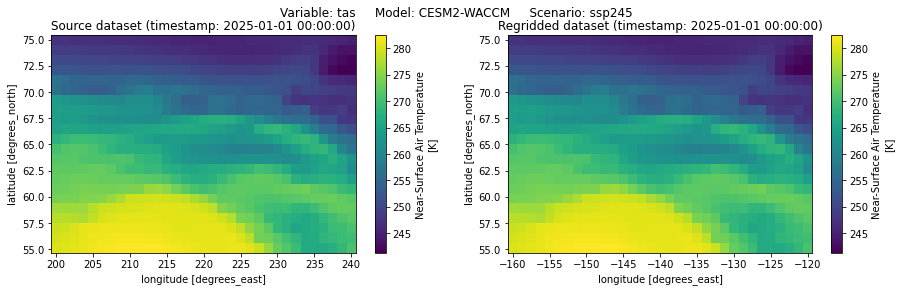

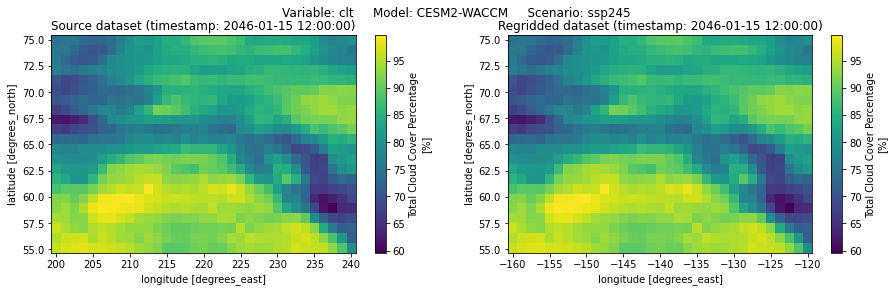

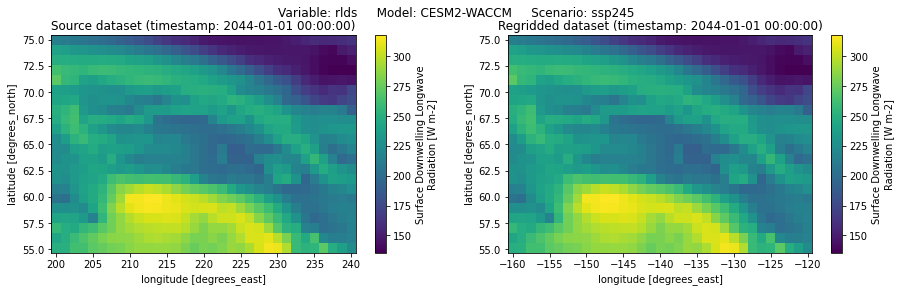

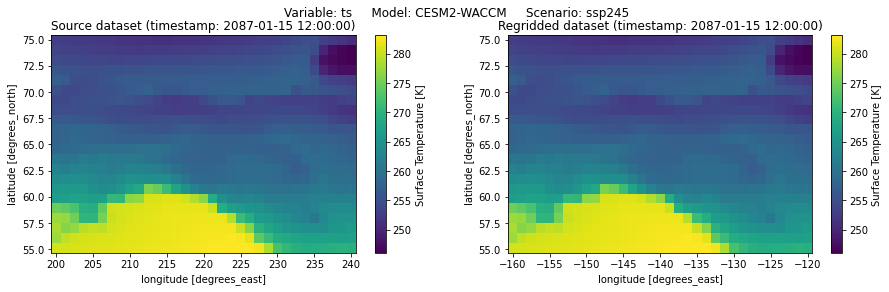

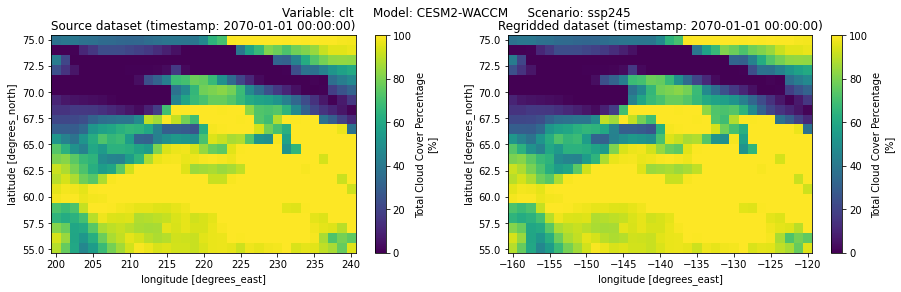

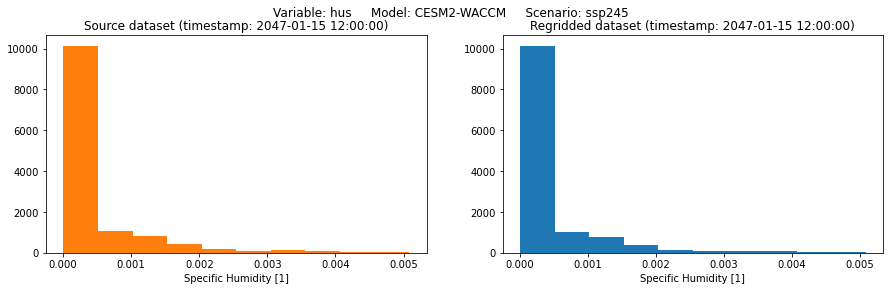

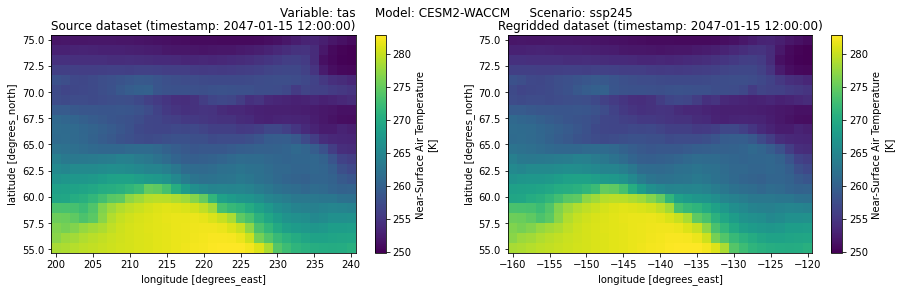

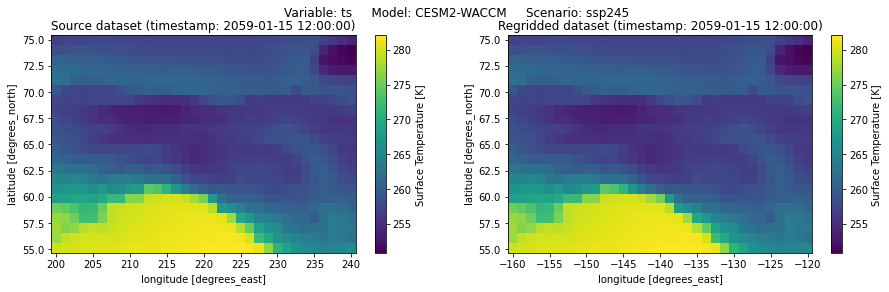

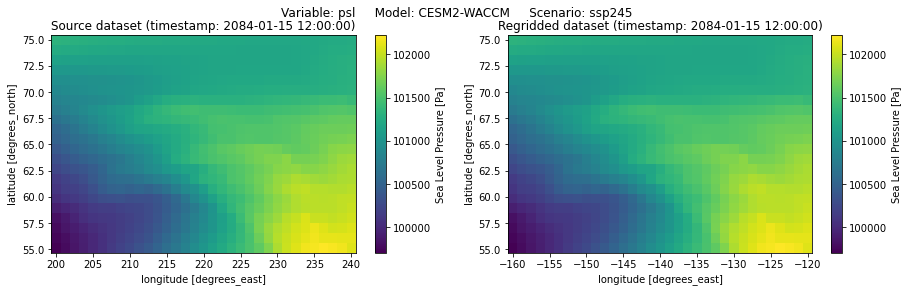

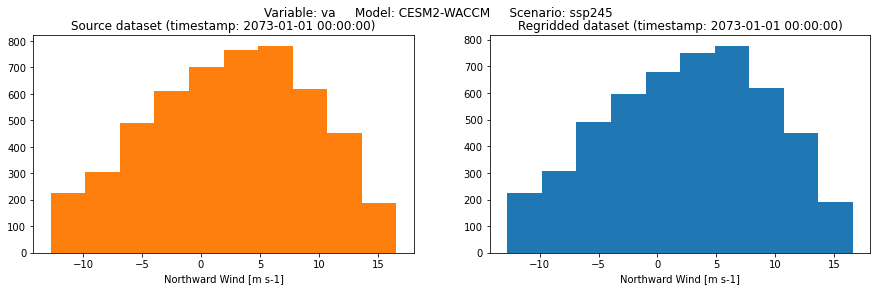

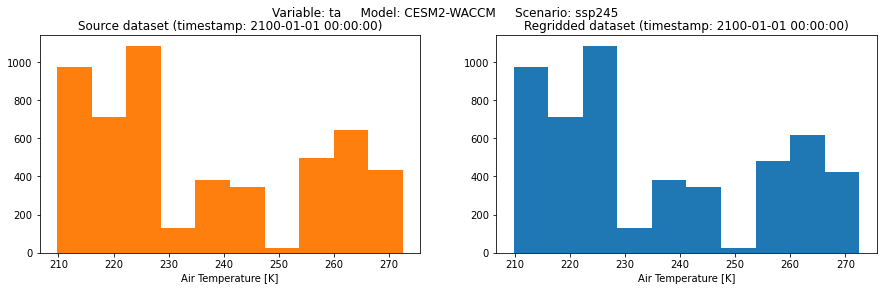

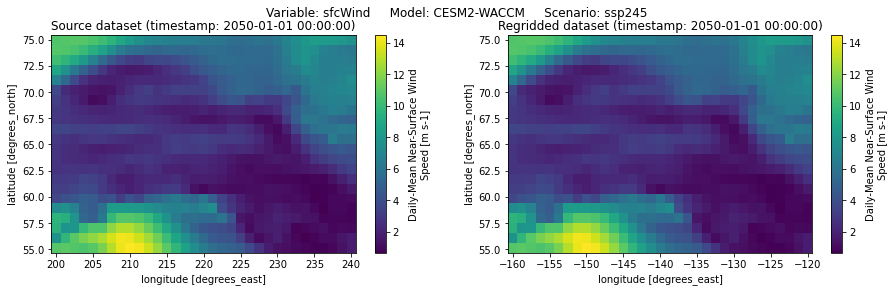

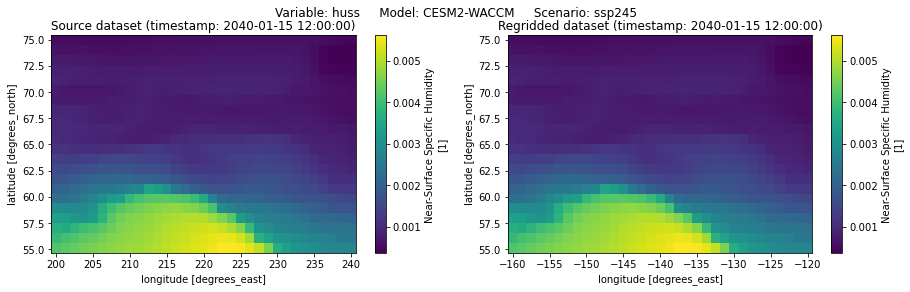

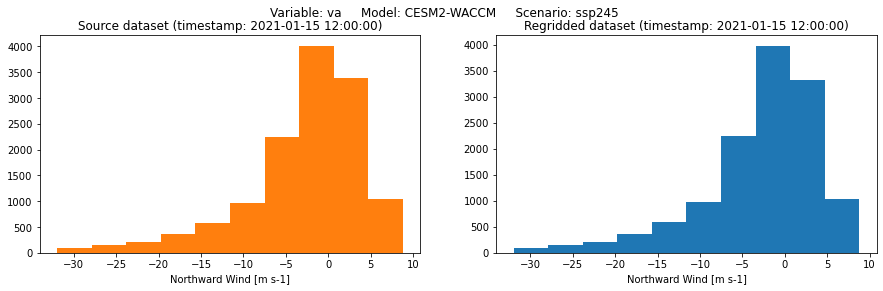

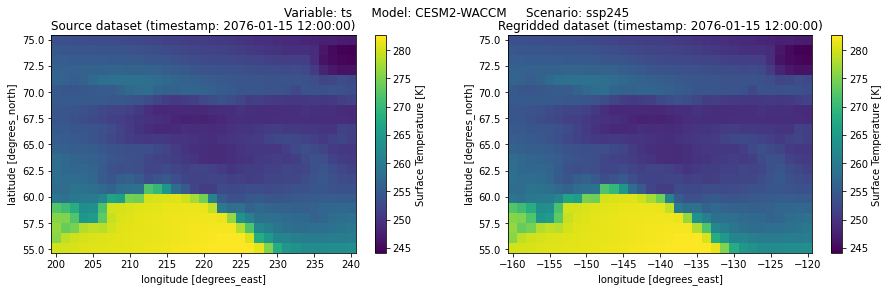

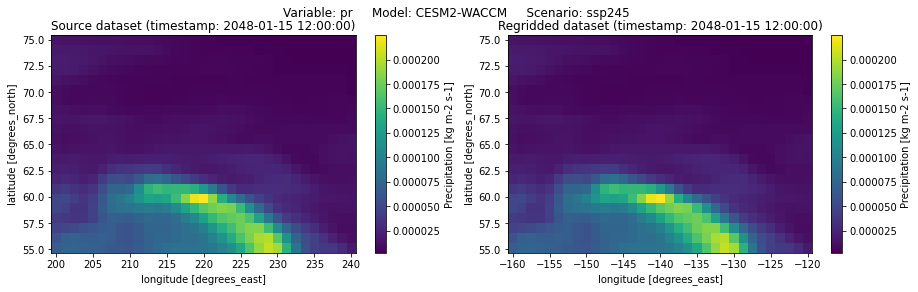

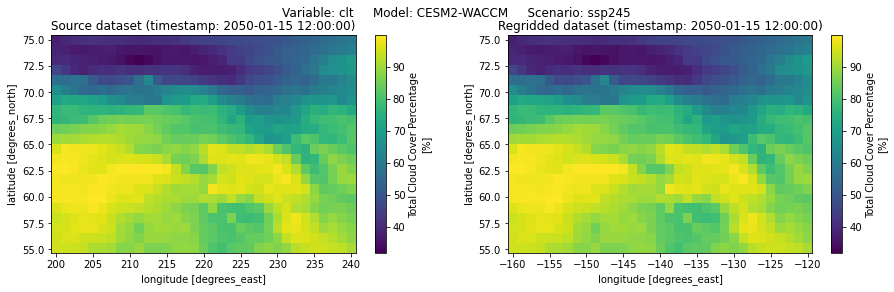

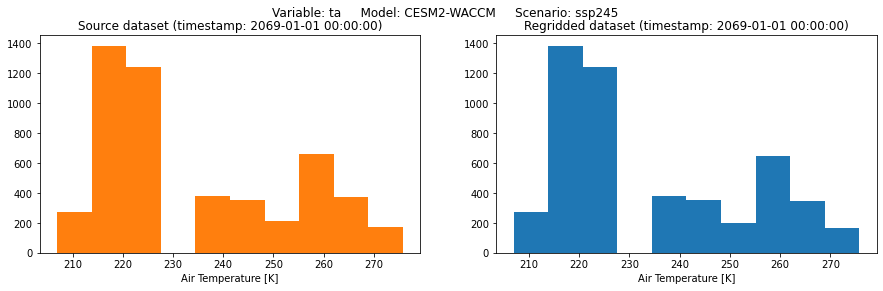

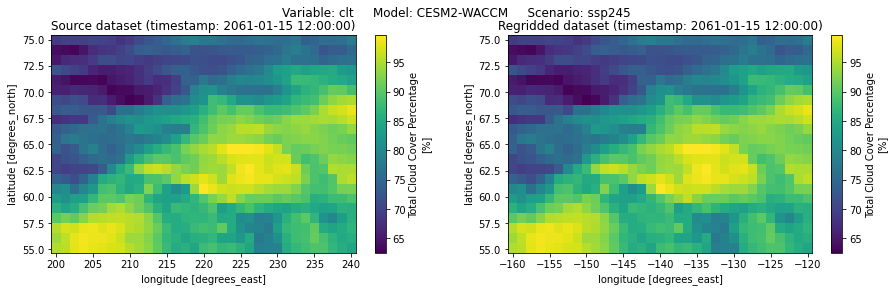

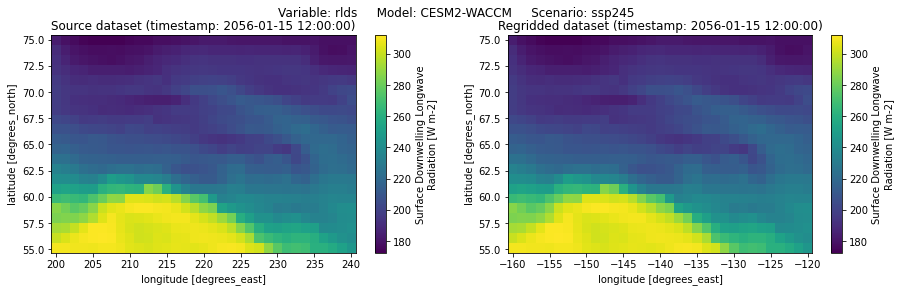

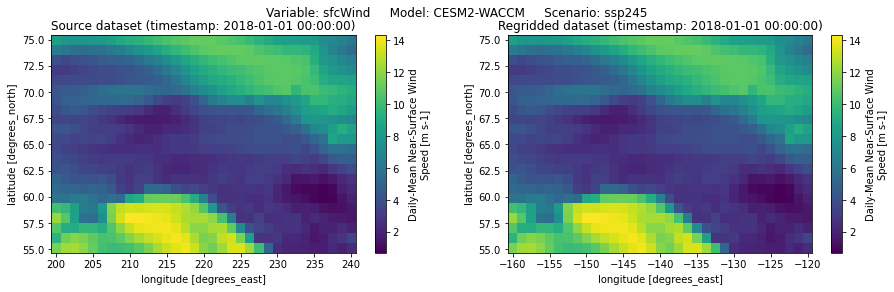

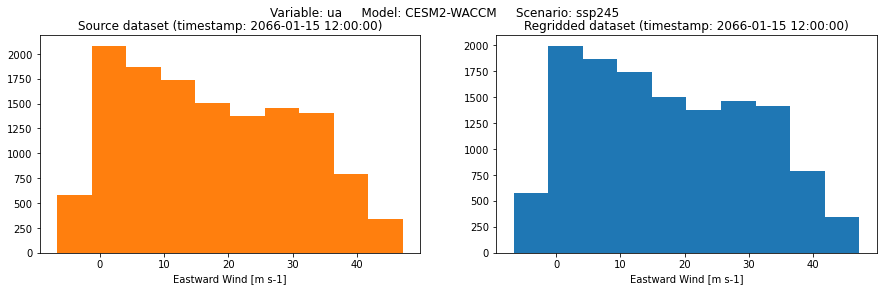

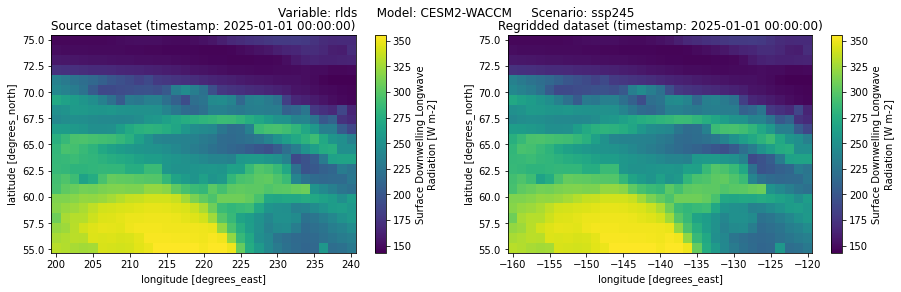

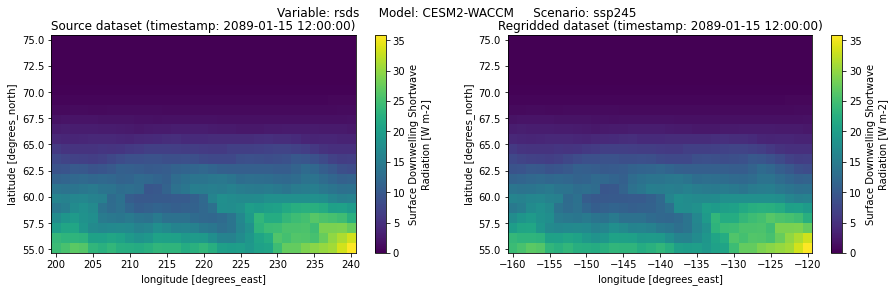

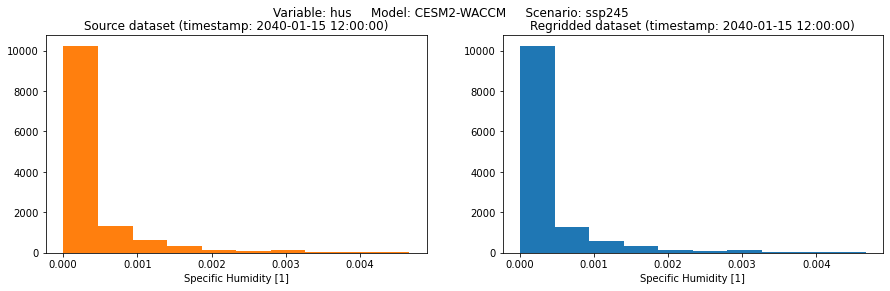

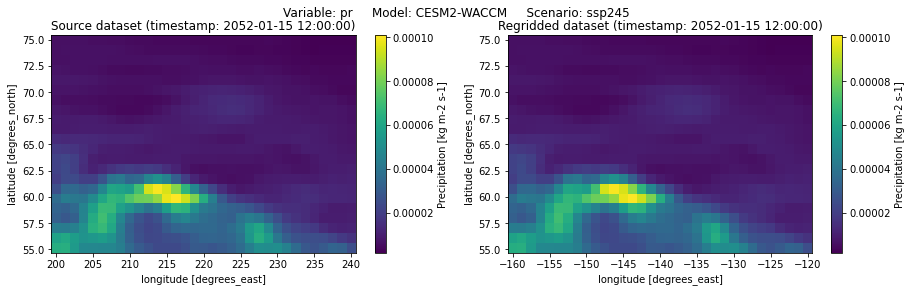

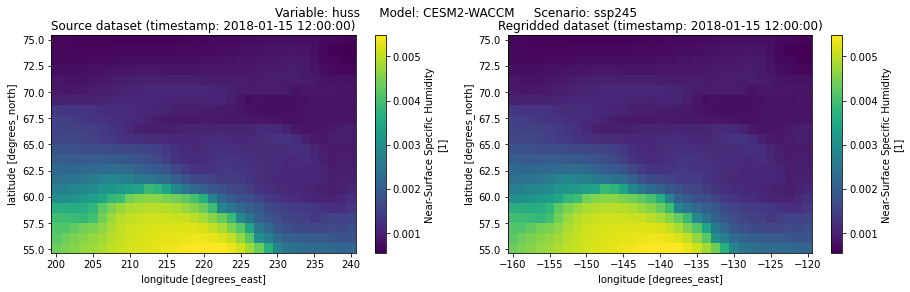

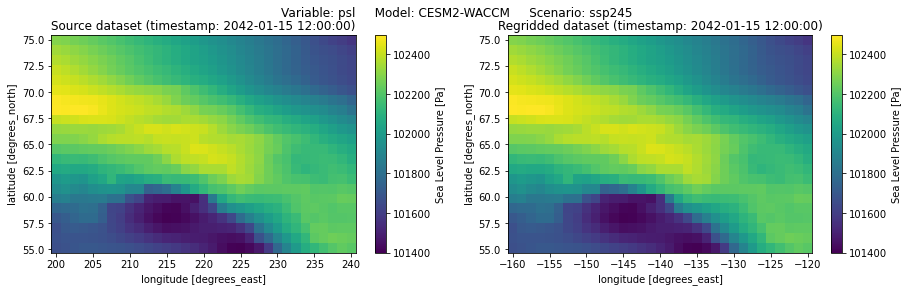

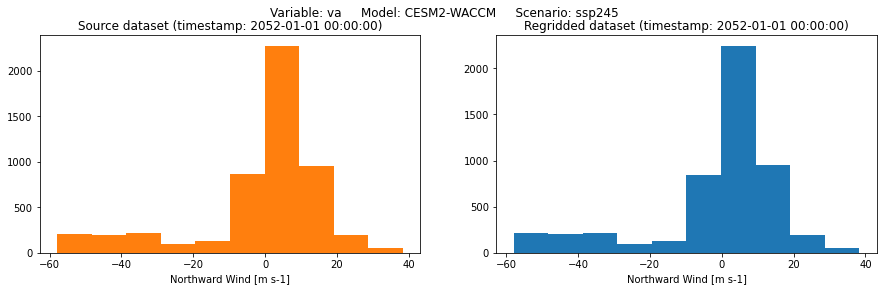

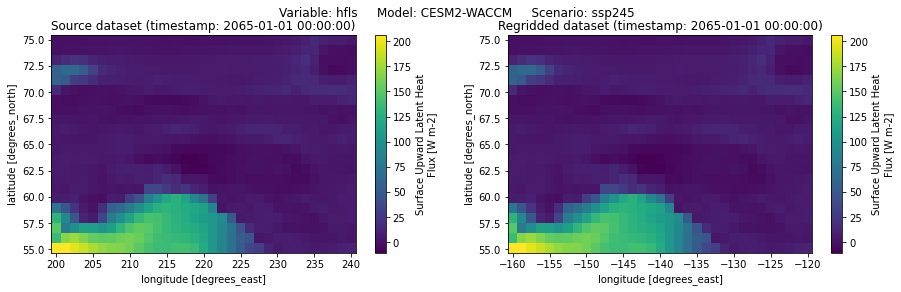

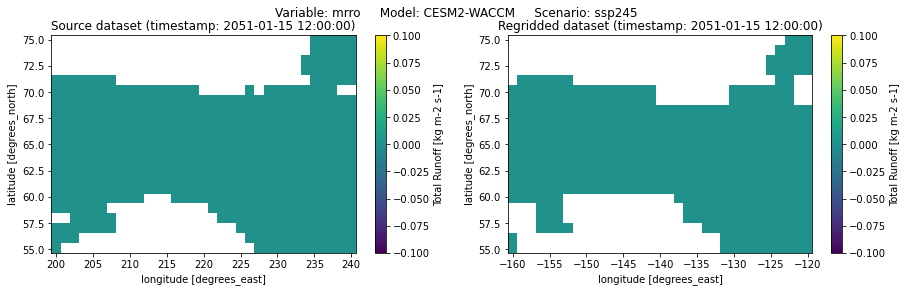

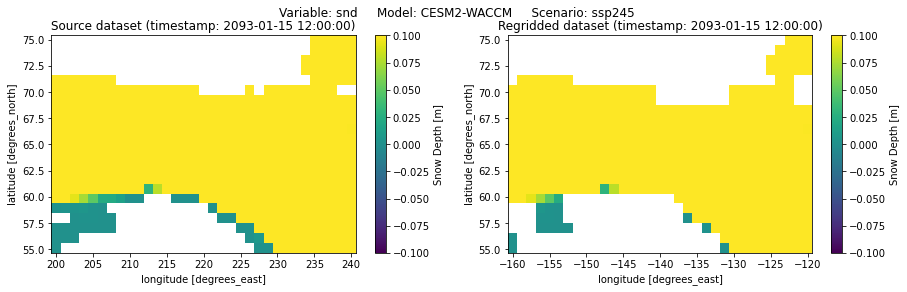

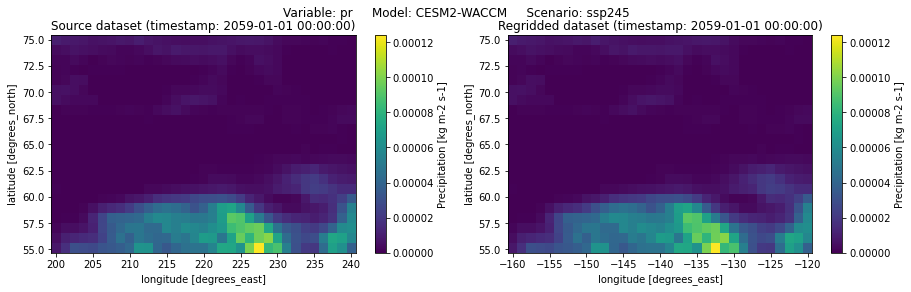

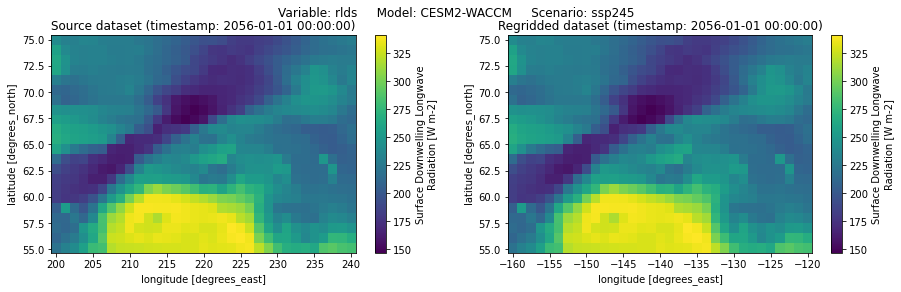

In [15]:
for i in range(100):
    fp = np.random.choice(regrid_fps)
    plot_comparison(fp)
